In [ ]:
#@title GridBanditEnv
import numpy as np
import matplotlib.pyplot as plt


class GridBanditEnv:
    def __init__(self, grid_size=8, search_horizon=25, seed=None):
        self.grid_size = grid_size
        self.search_horizon = search_horizon
        np.random.seed(seed)
        self.normalized_reward_grid = self.create_spatially_correlated_rewards()
        self.visited_grid = np.zeros((grid_size, grid_size))
        self.reward_grid = np.zeros((grid_size, grid_size))  # unique for each round
        self.trials_played = 0
        self.grid_max = np.random.uniform(30, 40)  # changes every round


    def rbf_kernel(self, loc1, loc2, lambda_val):
        """Compute RBF kernel value for two locations."""
        distance = np.linalg.norm(np.array(loc1) - np.array(loc2))
        return np.exp(-distance / (2 * lambda_val**2))

    def create_spatially_correlated_rewards(self, lambda_val=2, num_centers=5):
        # Number of centers of influence
        center_locs = [tuple(np.random.randint(0, self.grid_size, 2)) for _ in range(num_centers)]

        # Assign random raw rewards to these centers
        center_rewards = np.random.rand(num_centers)

        # Create a grid for correlated rewards
        correlated_rewards = np.zeros((self.grid_size, self.grid_size))

        # Compute the influence of these centers on the entire grid using the RBF kernel
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                for center, reward in zip(center_locs, center_rewards):
                    correlated_rewards[i, j] += reward * self.rbf_kernel((i, j), center, lambda_val)
        # print(correlated_rewards)

        # Normalize the rewards to lie between 0 and 40 and round to nearest integer
        min_reward = correlated_rewards.min()
        max_reward = correlated_rewards.max()
        normalized_rewards = (correlated_rewards - min_reward) / (max_reward - min_reward)
        # print(normalized_rewards)
        return normalized_rewards

    def plot_reward_heatmap(self, normalized=True):
        plt.figure(figsize=(10, 10))
        if normalized:
          reward_grid = self.normalized_reward_grid
        else:
          reward_grid = self.reward_grid
        # Plotting the heatmap
        plt.imshow(reward_grid, cmap='viridis', interpolation='none')

        # Adding the values of each cell to the heatmap
        for i in range(reward_grid.shape[0]):
            for j in range(reward_grid.shape[1]):
                plt.text(j, i, f"{reward_grid[i, j]:.2f}", ha='center', va='center', color='white')

        plt.colorbar()
        plt.title("Reward Grid Heatmap")
        plt.show()

    def plot_visited_reward_heatmap(self, n_trial, normalized=False):
        plt.figure(figsize=(10, 10))

        # Mask the reward grid based on visited tiles
        if normalized:
          reward_grid = self.normalized_reward_grid
        else:
          reward_grid = self.reward_grid
        masked_rewards = np.where(self.visited_grid, reward_grid, np.nan)

        # Plotting the heatmap
        plt.imshow(masked_rewards, cmap='viridis', interpolation='none', vmin=np.min(reward_grid), vmax=np.max(reward_grid))

        # Adding the values of each visited cell to the heatmap
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.visited_grid[i, j] == 1:
                    plt.text(j, i, f"{reward_grid[i, j]:.2f}", ha='center', va='center', color='white')

        plt.colorbar()
        plt.title(f"Visited Reward Grid Heatmap after trial {n_trial}")
        plt.show()

    def step(self, tile_coord, render=False):
        if self.trials_played >= self.search_horizon:
            raise Exception("End of search horizon, please reset the environment.")

        reward = np.random.normal(loc=self.reward_grid[tile_coord])  # corrupted by a gaussian noise N(0,1)
        norm_reward = self.normalized_reward_grid[tile_coord]
        self.visited_grid[tile_coord] = 1
        self.trials_played += 1
        if render:
          self.plot_visited_reward_heatmap(self.trials_played, normalized=False)
        return norm_reward, reward

    def reset(self):
        self.trials_played = 0
        self.visited_grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

        # Create spatially correlated rewards
        self.normalized_reward_grid = self.create_spatially_correlated_rewards()

        # Rescale the reward to between 5 and 45
        self.grid_max = np.random.uniform(30, 40)
        self.reward_grid = self.grid_max * self.normalized_reward_grid
        self.reward_grid += 5  # to avoid having negative reward given the noise

        # Randomly reveal a tile at the beginning
        self.current_tile = (np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size))
        return self.current_tile



In [ ]:
#@title Q-learning agent
class QLearningAgent:
    def __init__(self, grid_size=8, alpha=0.1, gamma=0.9, epsilon=0.1, seed=None):
        self.grid_size = grid_size
        self.Q = np.zeros((grid_size, grid_size))  # Initializing Q-values to zero
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        np.random.seed(seed)

    def choose_action(self, visited_grid):
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: Randomly select an unvisited tile
            unvisited_tiles = np.argwhere(visited_grid == 0)
            return tuple(unvisited_tiles[np.random.choice(len(unvisited_tiles))])
        else:
            # Exploitation: Choose the tile with the highest Q-value among unvisited tiles
            max_val = -np.inf
            best_tile = None
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    if visited_grid[i, j] == 0 and self.Q[i, j] > max_val:
                        max_val = self.Q[i, j]
                        best_tile = (i, j)
            return best_tile

    def update(self, tile_coord, reward, visited_grid):
        i, j = tile_coord
        # Update Q-value for the selected action
        max_future_q = np.max(self.Q[visited_grid == 0])
        self.Q[i, j] += self.alpha * (reward + self.gamma * max_future_q - self.Q[i, j])

    def reset(self):
        self.Q = np.zeros((self.grid_size, self.grid_size))  # Initializing Q-values to zero

In [ ]:
#@title GP-UCB agent
from scipy.optimize import minimize
from scipy.special import softmax

class GPR_UCB_Agent:
    def __init__(self, grid_size=8, lambda_val=2.0, beta=2.0, tau=1.0, seed=None):
        self.grid_size = grid_size
        self.lambda_val = lambda_val
        self.beta = beta
        self.tau = tau
        np.random.seed(seed)
        self.X_train = []  # List of previously chosen tiles
        self.y_train = []  # List of rewards received for chosen tiles

    def rbf_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(np.array(x1) - np.array(x2))**2 / (2 * self.lambda_val**2))

    def predict(self, X):
        if len(self.X_train) == 0:
            return np.zeros(len(X)), np.zeros(len(X))

        K = np.zeros((len(self.X_train), len(self.X_train)))
        for i in range(len(self.X_train)):
            for j in range(len(self.X_train)):
                K[i, j] = self.rbf_kernel(self.X_train[i], self.X_train[j])

        K_s = np.zeros((len(self.X_train), len(X)))
        for i in range(len(self.X_train)):
            for j in range(len(X)):
                K_s[i, j] = self.rbf_kernel(self.X_train[i], X[j])

        K_ss = np.zeros((len(X), len(X)))
        for i in range(len(X)):
            for j in range(len(X)):
                K_ss[i, j] = self.rbf_kernel(X[i], X[j])

        K_inv = np.linalg.inv(K + 1 * np.eye(len(self.X_train))) # std of reward noise is 1

        # Posterior mean
        mu_s = K_s.T.dot(K_inv).dot(self.y_train)

        # Posterior covariance
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

        # Ensuring diagonal entries are non-negative
        var_s = np.diag(cov_s)
        var_s = np.copy(var_s)
        var_s[var_s < 0] = 0

        return mu_s, var_s

    def choose_tile(self):
        all_tiles = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        mu, var = self.predict(all_tiles)
        q_values = mu + self.beta * np.sqrt(var)

        # Convert q-values to choice probabilities via softmax
        choice_probs = softmax(q_values / self.tau)
        if np.any(np.isnan(choice_probs)):
          breakpoint()
        chosen_tile_index = np.random.choice(len(all_tiles), p=choice_probs)
        return all_tiles[chosen_tile_index]

    def update(self, chosen_tile, reward):
        self.X_train.append(chosen_tile)
        self.y_train.append(reward)

    def reset(self):
        self.X_train = []
        self.y_train = []


In [ ]:
#@title SR agent

class SRAgent:
    def __init__(self, grid_size=8, alpha=0.1, discount_factor=0.9, epsilon=0.1):
        self.grid_size = grid_size
        self.lr = alpha
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.M = np.eye(grid_size * grid_size)  # Initialize the SR matrix as an identity matrix
        self.reward_estimates = np.zeros(grid_size * grid_size)

    def _flatten_coord(self, coord):
        return coord[0] * self.grid_size + coord[1]

    def _unflatten_index(self, index):
        return divmod(index, self.grid_size)

    def update(self, current_coord, reward):
        current_idx = self._flatten_coord(current_coord)

        # Update the SR using TD learning
        td_error = np.eye(self.grid_size * self.grid_size)[current_idx] + self.gamma * self.M[current_idx] - self.M[current_idx]
        self.M[current_idx] += self.lr * td_error

        # Update the estimated reward for the current state
        self.reward_estimates[current_idx] = reward

    def choose_tile(self, visited_tiles):
        # Compute the value of each state using the SR
        values = np.dot(self.M, self.reward_estimates)

        # Set the value of visited tiles to a very negative value to avoid revisiting
        for tile in visited_tiles:
            idx = self._flatten_coord(tile)
            values[idx] = -1e9

        # Choose the state with the highest value
        best_tile_index = np.argmax(values)
        return self._unflatten_index(best_tile_index)

    def reset(self):
        self.M = np.eye(self.grid_size * self.grid_size)  # Initialize the SR matrix as an identity matrix
        self.reward_estimates = np.zeros(self.grid_size * self.grid_size)

In [ ]:
#@title define helper functions for plotting results (single agent)

def plot_mean_reward(norm_rewards, **kwargs):
    """
    Plots the normalized mean reward over trials, averaged across all rounds.

    Parameters:
    - rewards: A list of lists that consists of the rewards received for each trial of each round.
    """
    # Convert the list of lists to a numpy array for easier calculations
    normalized_rewards_array = np.array(norm_rewards)

    # Calculate the mean reward for each trial across all rounds
    mean_rewards = np.mean(normalized_rewards_array, axis=0)
    std_rewards = np.std(normalized_rewards_array, axis=0)
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rewards, '-o', label='Average Normalized Reward')
    plt.fill_between(np.arange(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.2)
    plt.xlabel('Trial Number')
    plt.ylabel('Average Normalized Reward')
    plt.title('Mean Reward over Trials')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_max_reward(norm_rewards, **kwargs):
    """
    Plots the maximum reward earned up until a given trial, averaged across all rounds.

    Parameters:
    - rewards: A list of lists that consists of the rewards received for each trial of each round.
    """
    # Convert the list of lists to a numpy array for easier calculations
    normalized_rewards_array = np.array(norm_rewards)

    # Calculate the maximum reward earned up until the give trial
    normalized_maximum_cumulative_rewards = np.maximum.accumulate(normalized_rewards_array, axis=1)

    # average across rounds
    mean_rewards = np.mean(normalized_maximum_cumulative_rewards, axis=0)
    std_rewards = np.std(normalized_maximum_cumulative_rewards, axis=0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rewards, '-o', label='Maximum Normalized Reward')
    plt.fill_between(np.arange(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.2)
    plt.xlabel('Trial Number')
    plt.ylabel('Running Maximum Normalized Reward')
    plt.title('Max Reward over Trials')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def count_unique_tiles(tile_coordinates):
    """
    Count the number of unique tile coordinates chosen for each trial in each round.

    Parameters:
    - tile_coordinates: A list of lists where each inner list consists of the chosen tile coordinates for each trial.

    Returns:
    - A list of counts of unique tile coordinates for each trial in each round.
    """
    unique_tile_counts = []

    for round_coords in tile_coordinates:
        # Using set to identify unique tile coordinates for the round
        round_set = set(tuple(coord) for coord in round_coords)
        unique_tile_counts.append(len(round_set))

    return unique_tile_counts

def visualize_unique_tiles(tile_coordinates):
    unique_tile_counts = count_unique_tiles(tile_coordinates)

    # Plotting the unique tile counts
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(unique_tile_counts)), unique_tile_counts, align='center', alpha=0.7)
    plt.xlabel('Round Number')
    plt.ylabel('Number of Unique Tiles')
    plt.title('Number of Unique Tiles Chosen per Round')
    plt.tight_layout()
    plt.show()


def calculate_tile_distances(tile_coordinates):
    """
    Calculate the distance between consecutive tiles in each round.

    Parameters:
    - tile_coordinates: A list of lists where each inner list consists of the chosen tile coordinates for each trial.

    Returns:
    - A list of lists where each inner list consists of distances between consecutive tiles.
    """
    distances = []
    for round_coords in tile_coordinates:
        round_distances = []
        for i in range(1, len(round_coords)):
            dist = np.linalg.norm(np.array(round_coords[i]) - np.array(round_coords[i-1]))
            round_distances.append(dist)
        distances.append(round_distances)
    return distances

def plot_distance_vs_reward(tile_coordinates, rewards):
    distances = calculate_tile_distances(tile_coordinates)

    # Flatten lists and associate each distance with the previous reward
    all_distances = []
    all_rewards = []
    for i in range(len(rewards)):  # rounds
      all_rewards.append(rewards[i][:-1])
      all_distances.append(distances[i])
      assert len(all_rewards)==len(all_distances), "all_rewards and all_distances must have the same length!"

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(all_rewards, all_distances, alpha=0.3, label='Data points')
    # TODO: add "fixed effect of a hierarchical Bayesian regression"
    plt.xlabel('Previous Reward')
    plt.ylabel('Distance to Next Tile')
    plt.title('Distance to Next Tile vs. Previous Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
#@title define helper functions for plotting results (multiple agents)
import matplotlib.cm as cm
def plot_mean_reward_dict(norm_rewards_dict, **kwargs):
    """
    Plots the normalized mean reward over trials, averaged across all rounds.

    Parameters:
    - rewards: A list of lists that consists of the rewards received for each trial of each round.
    """

    # Plot the results
    plt.figure(figsize=(10, 10))
    for i, (config, norm_rewards) in enumerate(norm_rewards_dict.items()):
      # Convert the list of lists to a numpy array for easier calculations
      normalized_rewards_array = np.array(norm_rewards)
      # Calculate the mean reward for each trial across all rounds
      mean_rewards = np.mean(normalized_rewards_array, axis=0)
      std_rewards = np.std(normalized_rewards_array, axis=0)
      plt.plot(mean_rewards, '-o', label=config, color=colors[i])
      plt.fill_between(np.arange(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.1, color=colors[i])
    plt.xlabel('Trial Number')
    plt.ylabel('Average Normalized Reward')
    plt.title('Mean Reward over Trials')
    plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

def plot_max_reward_dict(norm_rewards_dict, **kwargs):
    """
    Plots the maximum reward earned up until a given trial, averaged across all rounds.

    Parameters:
    - rewards: A list of lists that consists of the rewards received for each trial of each round.
    """
    # Plot the results
    plt.figure(figsize=(10, 10))
    for i, (config, norm_rewards) in enumerate(norm_rewards_dict.items()):
      # Convert the list of lists to a numpy array for easier calculations
      normalized_rewards_array = np.array(norm_rewards)
      # Calculate the maximum reward earned up until the give trial
      normalized_maximum_cumulative_rewards = np.maximum.accumulate(normalized_rewards_array, axis=1)
      # average across rounds
      mean_rewards = np.mean(normalized_maximum_cumulative_rewards, axis=0)
      std_rewards = np.std(normalized_maximum_cumulative_rewards, axis=0)
      plt.plot(mean_rewards, '-o', label=config, color=colors[i])
      plt.fill_between(np.arange(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.1, color=colors[i])
    plt.xlabel('Trial Number')
    plt.ylabel('Running Maximum Normalized Reward')
    plt.title('Max Reward over Trials')
    plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    plt.show()


def visualize_unique_tiles_dict(tile_coordinates_dict, **kwargs):
    # Plotting the unique tile counts
    plt.figure(figsize=(10, 10))
    for i, (config, tile_coordinates) in enumerate(tile_coordinates_dict.items()):
      unique_tile_counts = count_unique_tiles(tile_coordinates)
      plt.plot(range(len(unique_tile_counts)), unique_tile_counts, label=config, color=colors[i], alpha=0.5)
    plt.xlabel('Round Number')
    plt.ylabel('Number of Unique Tiles')
    plt.title('Number of Unique Tiles Chosen per Round')
    plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

def visualize_relative_performance_dict(relative_performance_dict, **kwargs):
    # Plotting the unique tile counts
    plt.figure(figsize=(10, 10))
    for i, (config, relative_performance) in enumerate(relative_performance_dict.items()):
      plt.plot(range(len(relative_performance)), relative_performance, label=config, color=colors[i], alpha=0.5)
    plt.xlabel('Round Number')
    plt.ylabel('Relative Performance')
    plt.ylim(0,1)
    plt.title('Relative Performance per Round')
    plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

def plot_distance_vs_reward_dict(tile_coordinates_dict, rewards_dict, **kwargs):
    plt.figure(figsize=(10, 10))
    for i_config, (config, tile_coordinates, rewards) in enumerate(zip(tile_coordinates_dict.keys(),
                                                  tile_coordinates_dict.values(),
                                                  rewards_dict.values())):
        distances = calculate_tile_distances(tile_coordinates)
        # Flatten lists and associate each distance with the previous reward
        all_distances = []
        all_rewards = []
        for i in range(len(rewards)):  # rounds
          all_rewards.append(rewards[i][:-1])
          all_distances.append(distances[i])
          assert len(all_rewards)==len(all_distances), "all_rewards and all_distances must have the same length!"
        plt.scatter(all_rewards, all_distances, alpha=0.3, label=config, color=colors[i_config])
    # TODO: add "fixed effect of a hierarchical Bayesian regression" as red baseline
    plt.xlabel('Previous Reward')
    plt.ylabel('Distance to Next Tile')
    plt.title('Distance to Next Tile vs. Previous Reward')
    plt.legend()
    # plt.tight_layout()
    plt.show()


In [ ]:
#@title run (multiple agents)
def evaluate_agent_on_env(agent, env, num_rounds=100):
    """Evaluate agent's performance over multiple rounds."""
    scores = []  # relative performance
    behaviour_data = {
    "tile_coord": [],
    "reward": [],
    "norm_reward": [],
    "env_max_reward": []  # maximum expected reward, pre-noise
    }
    for round in range(num_rounds):
        env.reset()
        agent.reset()
        behaviour_data["env_max_reward"].append(np.max(env.reward_grid))
        total_reward = 0
        total_normalized_reward = 0
        tile_coord_round = []
        reward_round = []
        norm_reward_round = []
        for t in range(env.search_horizon):
            chosen_tile = agent.choose_tile()
            normalized_reward, reward = env.step(chosen_tile)
            agent.update(chosen_tile, reward)
            total_reward += reward
            total_normalized_reward += normalized_reward
            reward_round.append(reward)
            norm_reward_round.append(normalized_reward)
            tile_coord_round.append(chosen_tile)
        scores.append(total_normalized_reward/env.search_horizon)
        behaviour_data["tile_coord"].append(tile_coord_round)
        behaviour_data["reward"].append(reward_round)
        behaviour_data["norm_reward"].append(norm_reward_round)
    return scores, behaviour_data

# Values we want to experiment with
lambda_vals = [1.0, 2.0, 3.0, 4.0]
beta_vals = [1.0, 2.0, 3.0]
tau_vals = [0.5, 1.0, 1.5]

# Store results
results = {}  # relative peformance
behaviour_data_all = {
    "tile_coord": {},
    "reward": {},
    "norm_reward": {},
    "env_max_reward": {}
}

# Create environment instance
env = GridBanditEnv(seed=1)

# Iterate over all combinations
for lambda_val in lambda_vals:
    for beta_val in beta_vals:
        for tau_val in tau_vals:
            agent = GPR_UCB_Agent(beta=beta_val, tau=tau_val, lambda_val=lambda_val)
            scores, behaviour_data = evaluate_agent_on_env(agent, env, num_rounds=50)
            config = (lambda_val, beta_val, tau_val)
            results[config] = scores
            for key in behaviour_data_all.keys():
              behaviour_data_all[key][config] = behaviour_data[key]
            print(f"Lambda: {lambda_val}, Beta: {beta_val}, Tau: {tau_val} -> Avg Score: {np.mean(scores)}")

colormap = cm.get_cmap("tab10", len(results))
colors = [colormap(i) for i in range(len(results))]

visualize_relative_performance_dict(results, colors=colors)
plot_mean_reward_dict(behaviour_data_all["norm_reward"], colors=colors)
plot_max_reward_dict(behaviour_data_all["norm_reward"], colors=colors)
visualize_unique_tiles_dict(behaviour_data_all["tile_coord"], colors=colors)
plot_distance_vs_reward_dict(behaviour_data_all["tile_coord"], behaviour_data_all["norm_reward"], colors=colors)

<ipython-input-18-0654a181913e>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("gist_ncar", len(results))


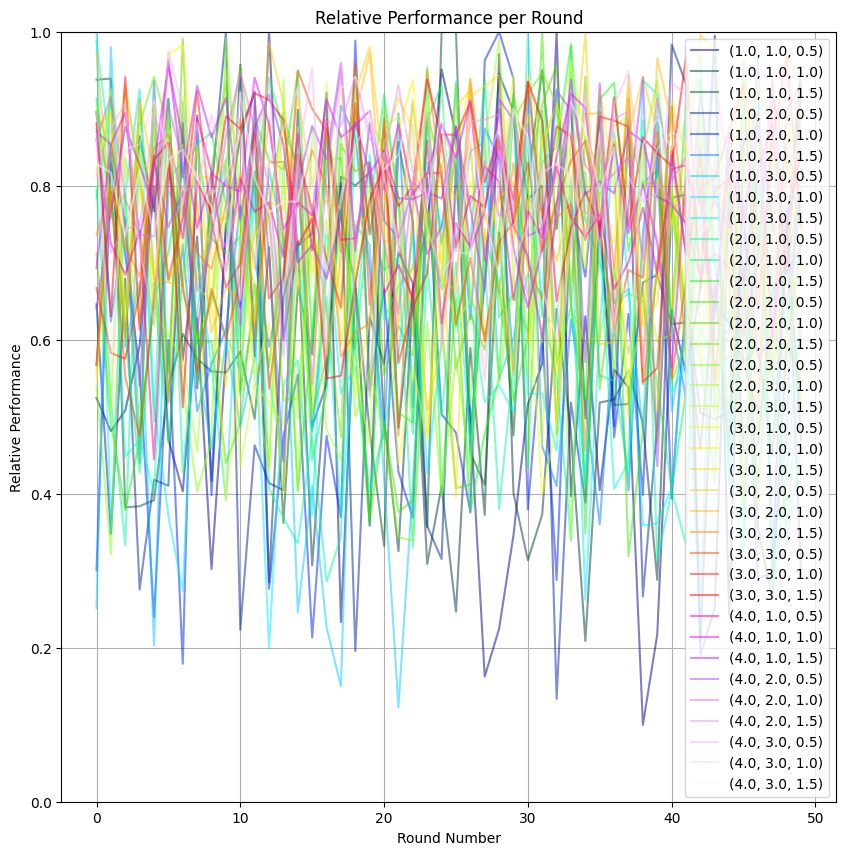

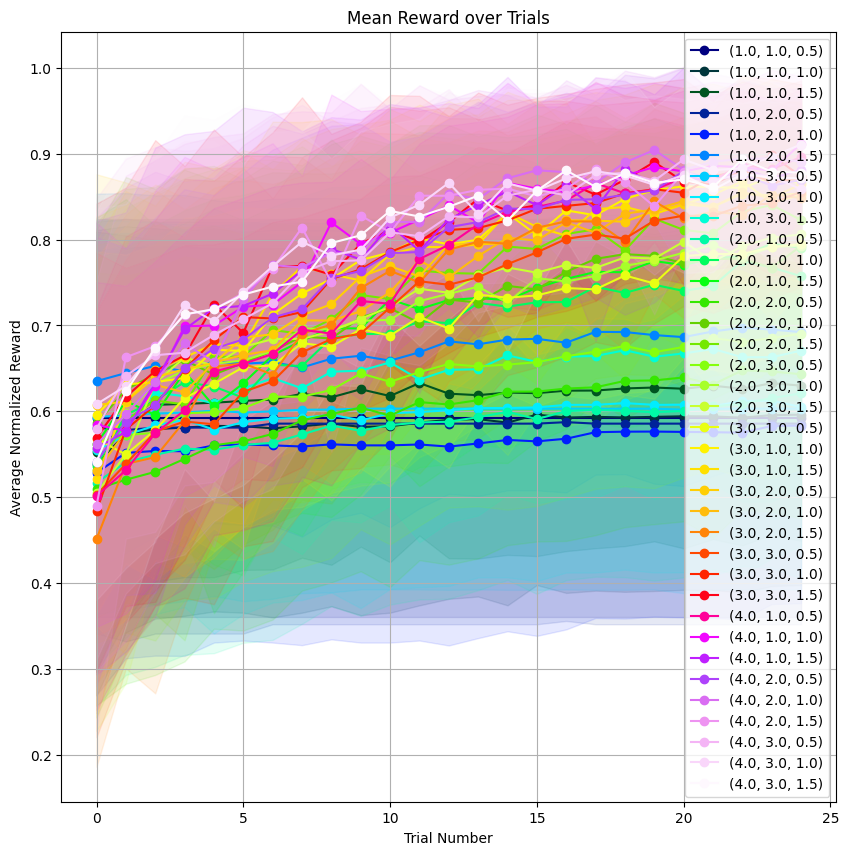

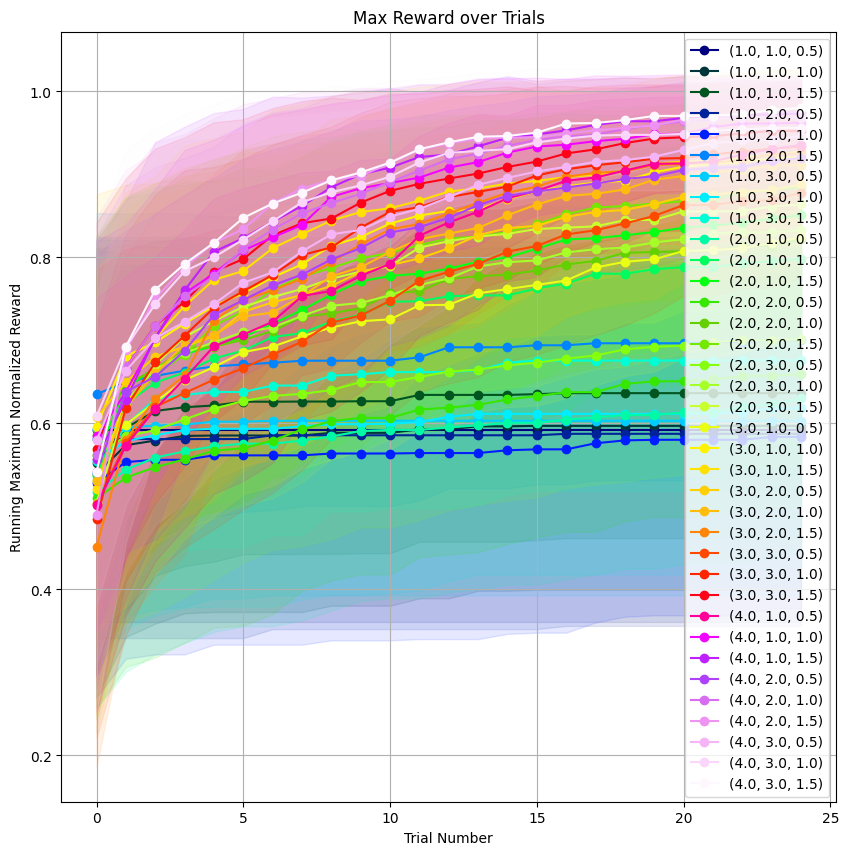

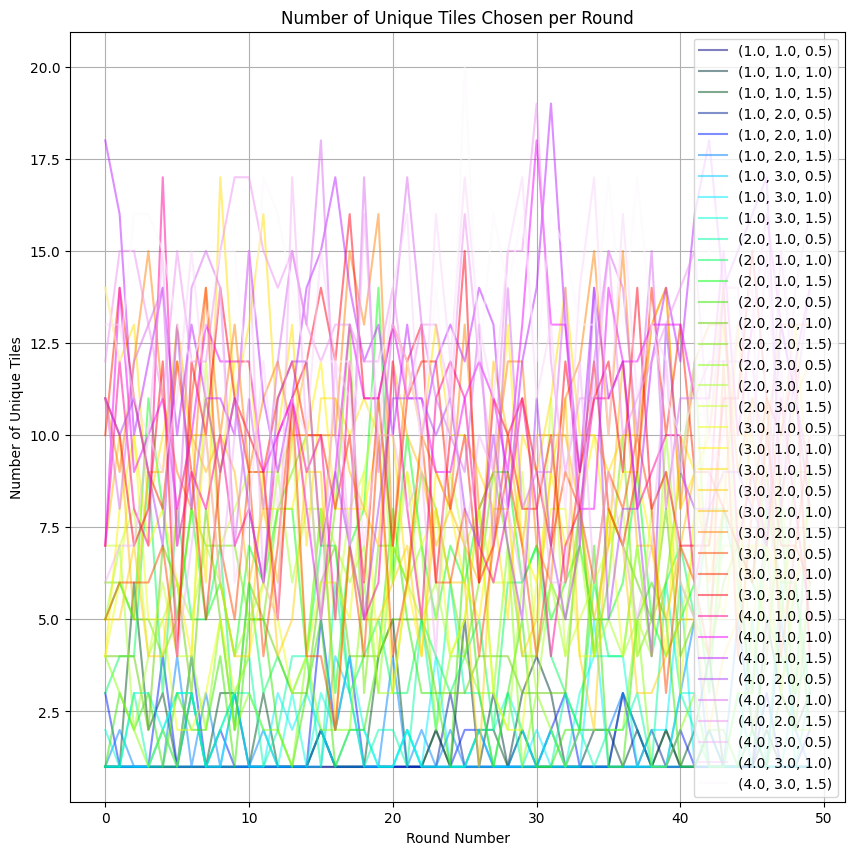

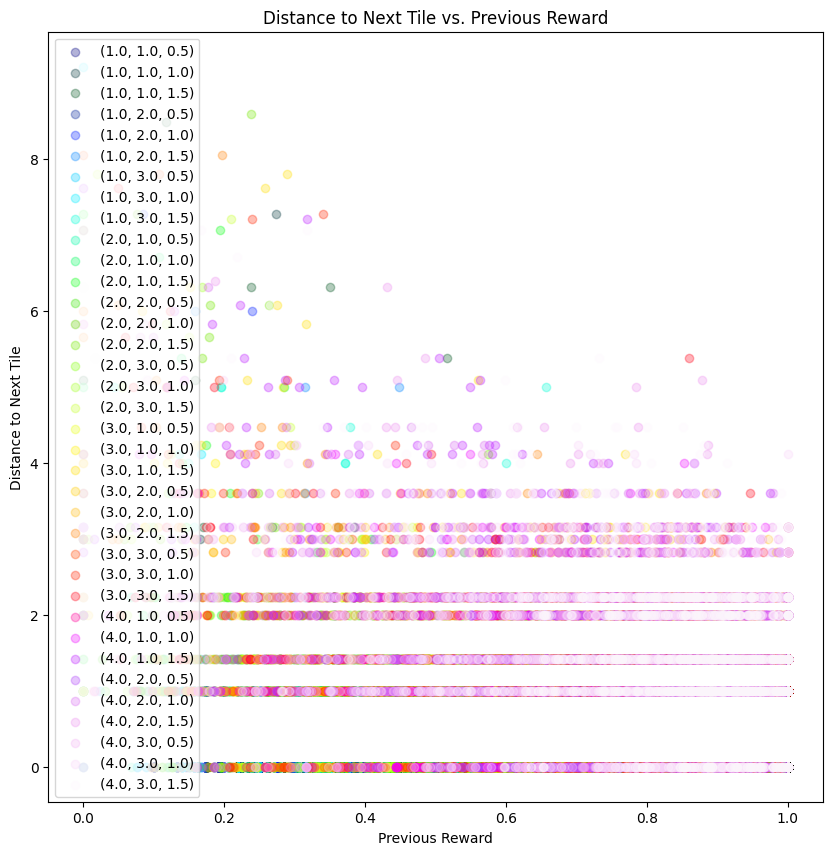

In [ ]:
colormap = cm.get_cmap("gist_ncar", len(results))
colors = [colormap(i) for i in range(len(results))]

visualize_relative_performance_dict(results, colors=colors)
plot_mean_reward_dict(behaviour_data_all["norm_reward"], colors=colors)
plot_max_reward_dict(behaviour_data_all["norm_reward"], colors=colors)
visualize_unique_tiles_dict(behaviour_data_all["tile_coord"], colors=colors)
plot_distance_vs_reward_dict(behaviour_data_all["tile_coord"], behaviour_data_all["norm_reward"], colors=colors)

100%|██████████| 50/50 [00:00<00:00, 239.27it/s]


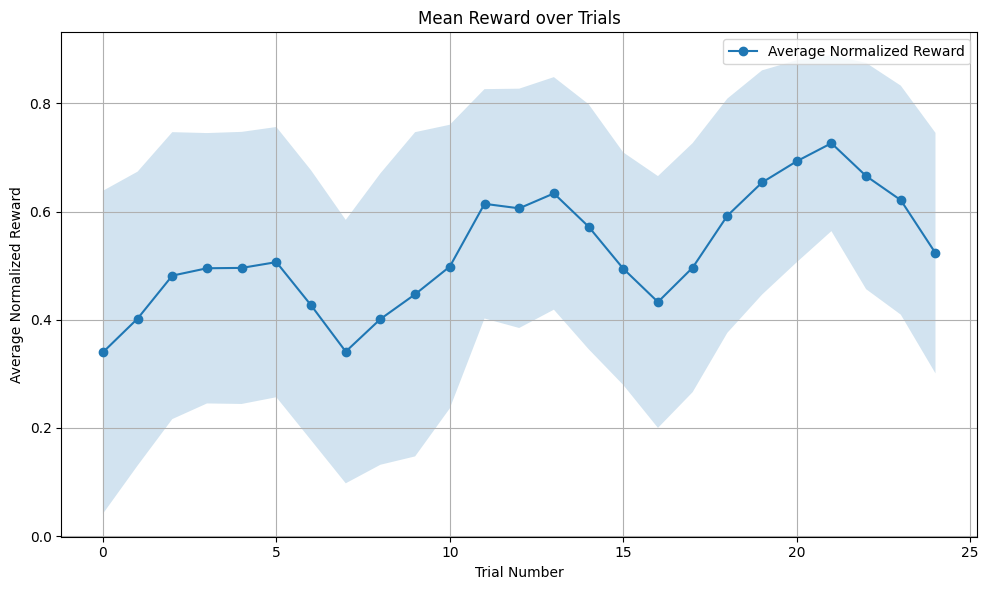

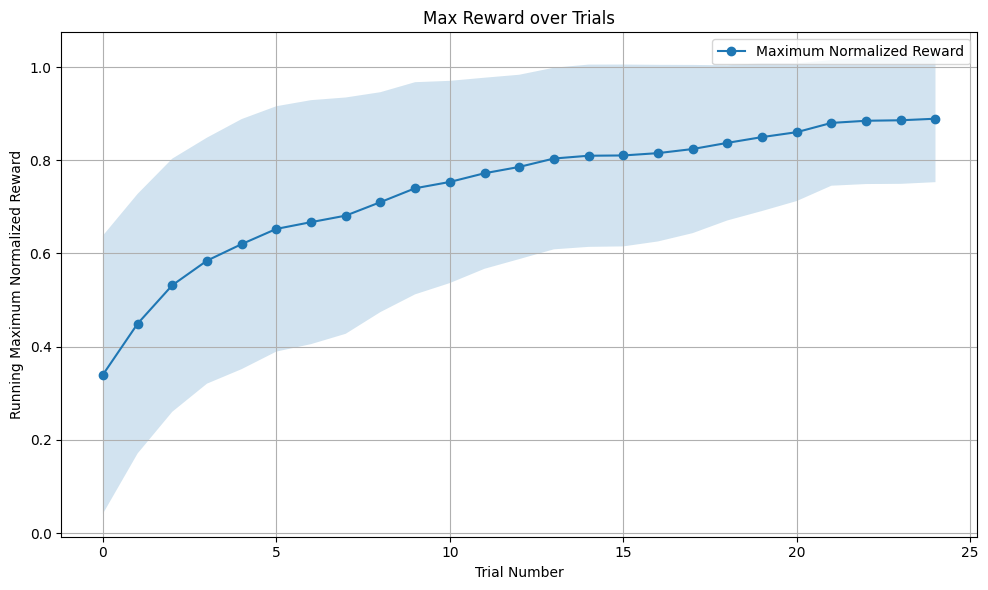

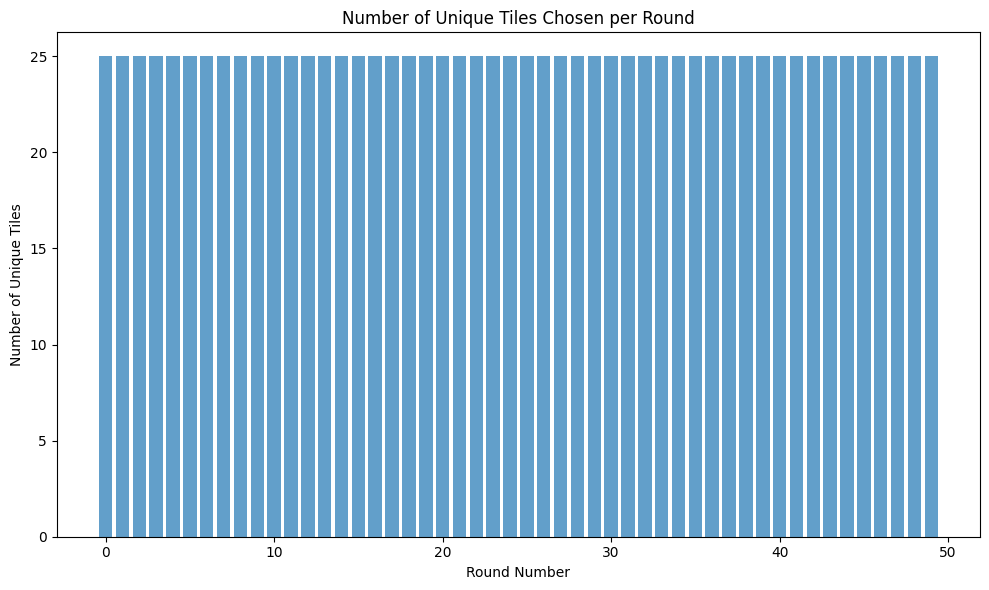

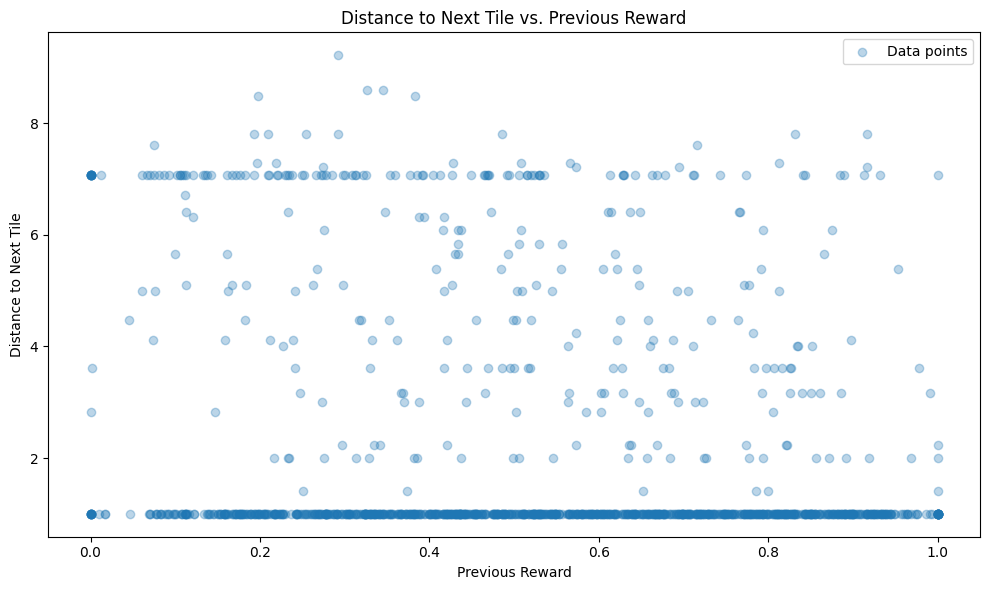

In [ ]:
#@title run (single agent)
from tqdm import tqdm
# Initialize environment and agent
env = GridBanditEnv(seed=1)
# agent = GPR_UCB_Agent(seed=1)
# agent = SRAgent()
agent = QLearningAgent(seed=1, epsilon=0.1)

behaviour_data = {
    "tile_coord": [],
    "reward": [],
    "norm_reward": [],
    "env_max_reward": []  # maximum expected reward, pre-noise
}

num_rounds = 50

for round in tqdm(range(num_rounds)):
    # Start a new round
    env.reset()
    agent.reset()  # reset X_train and y_train, or Q, or M and reward estimate
    # env.plot_reward_heatmap(normalized=True)
    behaviour_data["env_max_reward"].append(np.max(env.reward_grid))

    total_reward = 0
    total_normalized_reward = 0
    tile_coord_round = []
    reward_round = []
    norm_reward_round = []
    for trial in range(env.search_horizon):

        if isinstance(agent, SRAgent): # For SR agent
          chosen_tile = agent.choose_tile(np.argwhere(env.visited_grid == 1))
          normalized_reward, reward = env.step(chosen_tile, render=False)
          agent.update(chosen_tile, reward)

        elif isinstance(agent, QLearningAgent): # For Q-Learning agent
          chosen_tile = agent.choose_action(env.visited_grid)
          normalized_reward, reward = env.step(chosen_tile, render=False)
          agent.update(chosen_tile, reward, env.visited_grid)

        elif isinstance(agent, GPR_UCB_Agent): # For GP-UCB agent
          chosen_tile = agent.choose_tile()
          normalized_reward, reward = env.step(chosen_tile, render=False)
          agent.update(chosen_tile, reward)


        # Record data
        total_reward += reward
        total_normalized_reward += normalized_reward
        reward_round.append(reward)
        norm_reward_round.append(normalized_reward)
        tile_coord_round.append(chosen_tile)

    # Print performance after each round
    # print(f"Round {round + 1} - Total Reward: {total_reward}, Relative Performance: {total_normalized_reward/env.search_horizon:.2f}")
    behaviour_data["tile_coord"].append(tile_coord_round)
    behaviour_data["reward"].append(reward_round)
    behaviour_data["norm_reward"].append(norm_reward_round)

plot_mean_reward(behaviour_data["norm_reward"])
plot_max_reward(behaviour_data["norm_reward"])
visualize_unique_tiles(behaviour_data["tile_coord"])
plot_distance_vs_reward(behaviour_data["tile_coord"], behaviour_data["norm_reward"])